<a href="https://colab.research.google.com/github/XingxinHE/FinalThesis_DL-GA/blob/master/Stage_3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Mounted at /content/gdrive


In [4]:
os.chdir("/content/gdrive/My Drive/Final Thesis/data/stage3")

## Data Preparation

### Loading Input

In [5]:
train_x = pd.read_csv('605_coord.csv', index_col=0)
train_x.drop(columns=list('2568'), axis=1, inplace=True)

In [6]:
train_x.shape

(605, 5)

In [7]:
train_x.head()

,0,1,3,4,7
0,40.0,35.0,30.0,20.0,35.0
1,40.0,40.0,40.0,15.0,35.0
2,30.0,30.0,40.0,20.0,20.0
3,10.0,40.0,40.0,20.0,25.0
4,35.0,40.0,30.0,10.0,30.0


In [8]:
test_x = pd.read_csv('10_coord.csv', index_col=0)
test_x.drop(columns=list('2568'), axis=1, inplace=True)

In [9]:
test_x.shape

(10, 5)

In [10]:
test_x.tail()

,0,1,3,4,7
5,30.0,40.0,15.0,10.0,20.0
6,40.0,35.0,35.0,20.0,30.0
7,35.0,40.0,25.0,15.0,20.0
8,25.0,35.0,30.0,15.0,15.0
9,20.0,40.0,10.0,10.0,35.0


In [11]:
train_test = pd.concat([train_x, test_x])
train_test

,0,1,3,4,7
0,40.0,35.0,30.0,20.0,35.0
1,40.0,40.0,40.0,15.0,35.0
2,30.0,30.0,40.0,20.0,20.0
3,10.0,40.0,40.0,20.0,25.0
4,35.0,40.0,30.0,10.0,30.0
...,...,...,...,...,...
5,30.0,40.0,15.0,10.0,20.0
6,40.0,35.0,35.0,20.0,30.0
7,35.0,40.0,25.0,15.0,20.0
8,25.0,35.0,30.0,15.0,15.0


### Loading output

In [12]:
train_y = pd.read_csv('optimal_605.csv', index_col=0)
train_y.shape

(605, 2)

In [14]:
test_y = pd.read_csv('testing_10.csv', index_col=0)
test_y.shape

(10, 2)

In [15]:
#define a function convert np of object to np of float
def f(x):
    return np.array(x.replace('[', '').replace(']', '').replace(',', ' ').split()).astype(float)

In [16]:
train_y = np.array([f(t) for t in train_y['bar_orders']])
train_y = np.floor(train_y)
train_y = train_y.astype(int)
train_y.shape

(605, 220)

In [17]:
train_y

array([[2, 0, 1, ..., 0, 2, 1],
       [0, 0, 2, ..., 2, 0, 1],
       [2, 2, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 3, ..., 0, 3, 1],
       [1, 1, 2, ..., 0, 1, 2],
       [2, 3, 2, ..., 1, 0, 0]])

In [18]:
test_y = np.array([f(t) for t in test_y['bar_orders']])
test_y = np.floor(test_y)
test_y = test_y.astype(int)
test_y.shape

(10, 220)

In [19]:
test_y

array([[1, 0, 2, ..., 0, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 3, ..., 1, 0, 0],
       ...,
       [2, 0, 1, ..., 2, 0, 2],
       [2, 2, 1, ..., 0, 0, 2],
       [0, 1, 2, ..., 2, 1, 2]])

### One-hot coding input

In [20]:
intput_features = len(train_x.columns)
intput_features

5

In [21]:
sorted(pd.unique(train_test[train_test.columns].values.ravel('K')))

[10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]

In [22]:
intput_features_possibilities = sorted(pd.unique(train_test[train_test.columns].values.ravel('K')))

In [23]:
intput_features_possibilities = [int(i) for i in intput_features_possibilities]
intput_features_possibilities

[10, 15, 20, 25, 30, 35, 40]

In [24]:
intput_features_possibilities_indices = dict((feature, intput_features_possibilities.index(feature)) for feature in intput_features_possibilities)
intput_features_possibilities_indices

{10: 0, 15: 1, 20: 2, 25: 3, 30: 4, 35: 5, 40: 6}

In [25]:
train_x_onehot = np.zeros((len(train_x.index), intput_features, len(intput_features_possibilities)), dtype=np.bool)
test_x_onehot = np.zeros((len(test_x.index), intput_features, len(intput_features_possibilities)), dtype=np.bool)

In [26]:
train_x_onehot.shape

(605, 5, 7)

In [27]:
test_x_onehot.shape

(10, 5, 7)

In [28]:
for i in range(len(train_x.index)):
  for j in range(len(train_x.columns)):
    train_x_onehot[i, j, intput_features_possibilities_indices[train_x.iloc[i,j]]] = 1

In [29]:
for i in range(len(test_x.index)):
  for j in range(len(test_x.columns)):
    test_x_onehot[i, j, intput_features_possibilities_indices[test_x.iloc[i,j]]] = 1

### One-hot coding output

In [30]:
output_features = train_y.shape[1]
output_features

220

In [31]:
np.unique(train_y)

array([0, 1, 2, 3])

In [32]:
output_features_possibilities = list(np.unique(train_y))

In [33]:
output_features_possibilities_indices = dict((feature, output_features_possibilities.index(feature)) for feature in output_features_possibilities)
output_features_possibilities_indices

{0: 0, 1: 1, 2: 2, 3: 3}

In [34]:
train_y_onehot = np.zeros((train_y.shape[0], train_y.shape[1], len(output_features_possibilities)), dtype=np.bool)
test_y_onehot = np.zeros((test_y.shape[0], test_y.shape[1], len(output_features_possibilities)), dtype=np.bool)

In [35]:
train_y_onehot.shape

(605, 220, 4)

In [36]:
test_y_onehot.shape

(10, 220, 4)

In [37]:
for i in range(train_y.shape[0]):
  for j in range(train_y.shape[1]):
    train_y_onehot[i, j, output_features_possibilities_indices[train_y[i,j]]] = 1

In [38]:
for i in range(test_y.shape[0]):
  for j in range(test_y.shape[1]):
    test_y_onehot[i, j, output_features_possibilities_indices[test_y[i,j]]] = 1

## Initialize Model (Softmax)

In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = keras.models.Sequential()
model.add(layers.LSTM(256, input_shape=(intput_features, len(intput_features_possibilities)))) 
model.add(layers.RepeatVector(output_features))
for _ in range(3):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(layers.LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.Dense(len(output_features_possibilities), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 256)               270336    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 220, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 220, 128)          197120    
_________________________________________________________________
lstm_6 (LSTM)                (None, 220, 128)          131584    
_________________________________________________________________
lstm_7 (LSTM)                (None, 220, 128)          131584    
_________________________________________________________________
dense_1 (Dense)              (None, 220, 4)            516       
Total params: 731,140
Trainable params: 731,140
Non-trainable params: 0
________________________________________________

In [41]:

history = model.fit(train_x_onehot, train_y_onehot,
          epochs=3000,
          batch_size=32,
          #validation_data = (x_test, y_test)
          validation_split = 0.2,
          )

Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 1s 32ms/step - loss: 1.1055 - accuracy: 0.4783 - val_loss: 1.6322 - val_accuracy: 0.3314
Epoch 502/3000
16/16 [==============================] - 1s 33ms/step - loss: 1.1182 - accuracy: 0.4723 - val_loss: 1.6130 - val_accuracy: 0.3275
Epoch 503/3000
16/16 [==============================] - 1s 34ms/step - loss: 1.1123 - accuracy: 0.4748 - val_loss: 1.6242 - val_accuracy: 0.3294
Epoch 504/3000
16/16 [==============================] - 1s 32ms/step - loss: 1.1033 - accuracy: 0.4800 - val_loss: 1.6319 - val_accuracy: 0.3266
Epoch 505/3000
16/16 [==============================] - 1s 33ms/step - loss: 1.0972 - accuracy: 0.4837 - val_loss: 1.6358 - val_accuracy: 0.3308
Epoch 506/3000
16/16 [==============================] - 1s 32ms/step - loss: 1.0992 - accuracy: 0.4833 - val_loss: 1.6396 - val_accuracy: 0.3311
Epoch 507/3000
16/16 [==============================] - 1s 32ms/step - loss: 1.1014 - accuracy

In [42]:
model.save('my_model_200921.h5')

## Prediction

In [43]:
test_predictions = model.predict(test_x_onehot)

In [44]:
test_predictions.shape

(10, 220, 4)

In [45]:
test_predictions

array([[[3.45610678e-01, 6.17646337e-01, 3.02663427e-02, 6.47670543e-03],
        [2.95053795e-02, 9.70479548e-01, 1.05311146e-05, 4.55397731e-06],
        [3.81466210e-01, 6.18533611e-01, 3.95798168e-08, 1.72015277e-07],
        ...,
        [1.03124917e-01, 5.02758443e-01, 3.24414492e-01, 6.97021857e-02],
        [1.18633144e-01, 4.96468633e-01, 3.24393719e-01, 6.05044365e-02],
        [1.38558790e-01, 4.87482131e-01, 3.21153879e-01, 5.28051555e-02]],

       [[2.01613516e-01, 6.19823337e-02, 7.29102492e-01, 7.30163930e-03],
        [5.76579608e-02, 6.59649432e-01, 2.82627523e-01, 6.50865841e-05],
        [1.14854216e-03, 9.66243505e-01, 3.25940512e-02, 1.40067996e-05],
        ...,
        [2.23384157e-01, 3.61619443e-01, 2.97238439e-01, 1.17757894e-01],
        [2.22773522e-01, 3.61638248e-01, 2.96851486e-01, 1.18736736e-01],
        [2.21895903e-01, 3.61545235e-01, 2.96094269e-01, 1.20464645e-01]],

       [[8.73730332e-03, 9.10957336e-01, 5.42959955e-04, 7.97624514e-02],
        

In [46]:
test_predictions = np.argmax(test_predictions,axis=-1)

In [48]:
for i in range(10):
  print(test_predictions[i])

[1 1 1 0 0 0 3 1 2 2 2 2 1 1 0 1 2 2 1 3 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 2
 2 1 0 1 2 0 0 1 2 1 0 0 1 1 1 1 1 1 1 1 1 3 3 2 2 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 1 2 2 0 0 1 0 0 2 2 2 2 1 2 2 2 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 0 0 2 2 1 0 3 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 1 1 1 1 2 2 2 2 2 2 3 3 3 2 2 2 2 2 2 1 1 1 1 1 1 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 2 2 2 2 2 3 3
 3 3 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 2 3 3 0 2 2 1 1 1 2 1 0 2 1 3 1 0 1 0 1 2 1 2 3 1 0 0 1 2 2 1 2
 2 1 1 1 1 1 0 2 2 1 1 1 1 0 0 

In [55]:
for i in range(10):
  print(test_y[i])

[1 0 2 0 3 2 2 1 2 2 1 1 1 3 1 2 2 2 3 0 1 2 1 1 0 1 0 2 1 1 1 0 2 2 0 1 0
 2 1 1 2 2 0 1 2 2 1 3 2 3 3 1 3 2 2 1 2 2 0 3 1 0 1 3 1 1 2 1 2 0 1 0 1 0
 3 2 0 2 0 0 3 2 2 1 0 2 2 0 0 2 3 2 1 1 1 0 2 1 0 2 0 0 0 2 2 0 2 1 2 0 2
 0 2 1 3 0 2 2 2 2 1 2 2 2 0 1 3 1 1 0 1 2 1 2 0 0 1 1 1 0 1 0 1 2 2 1 1 2
 1 1 1 0 2 2 1 1 2 3 2 0 2 1 2 3 2 0 0 1 2 3 2 2 2 1 2 2 1 1 1 1 1 1 0 1 2
 2 1 3 0 2 2 3 2 0 2 1 2 1 0 0 0 3 2 0 3 1 0 2 1 2 0 2 1 0 3 3 0 0 0 2]
[1 1 1 1 2 0 1 2 3 3 2 2 2 1 0 3 2 1 2 0 1 1 0 1 2 2 1 2 1 2 3 1 1 0 3 0 2
 1 0 1 2 1 0 0 2 0 0 1 1 1 2 1 1 1 1 1 1 0 1 1 2 1 2 1 3 2 0 2 3 1 2 2 0 0
 3 0 2 2 2 1 1 2 2 2 1 1 0 2 2 0 0 1 0 3 0 0 1 1 0 1 2 2 1 1 2 2 2 0 0 1 2
 0 2 1 3 2 2 3 3 1 3 1 0 2 2 0 2 0 3 0 0 0 1 1 2 1 1 1 2 2 2 0 1 0 1 1 1 2
 1 2 1 2 1 3 0 0 1 0 2 0 3 2 1 2 3 0 0 0 1 1 0 1 1 0 1 2 1 1 2 2 2 1 1 1 1
 1 1 3 0 1 1 2 3 2 2 1 2 2 0 2 2 2 0 0 2 1 2 2 1 1 0 2 1 2 0 2 0 1 1 1]
[1 1 3 2 1 0 2 0 1 0 0 0 0 1 2 0 2 0 2 3 3 1 2 1 2 2 1 1 0 2 1 2 0 1 1 1 2
 1 2 2 1 1 0 1 1 2 2 0 1 1 1 1 

In [57]:
test_y_raw

,bar_orders,weight
0,"1.266980124286869, 0.730679958020752, 2.711269...",114.448665
1,"1.6958148032167406, 1.7591587138881446, 1.2060...",106.610619
2,"1.7085216320647125, 1.4621386406536667, 3.5362...",102.109287
3,"3.7551681342158973, 1.990770038662044, 1.80226...",110.346827
4,"2.214742624257507, 0.6186439869353193, 3.49283...",114.621284
5,"0.9234232113919192, 1.6482721066715125, 0.0, 0...",111.679542
6,"1.172564922379456, 2.2300877394955734, 1.70185...",114.881194
7,"2.076408619577882, 0.10647776266119709, 1.3806...",110.441386
8,"2.5462705110867003, 2.3184685520032353, 1.3827...",105.344714
9,"0.5705349047075131, 1.6914648742655225, 2.3156...",116.785690


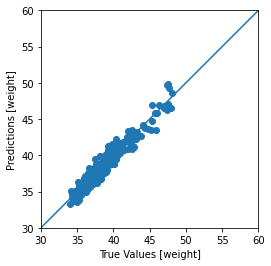

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(weight_pred, test_weight_label)
plt.xlabel('True Values [weight]')
plt.ylabel('Predictions [weight]')
lims = [30, 60]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
test_weight_label

141     49.664072
178     46.876165
180     46.752680
188     49.893984
207     46.951447
          ...    
2527    34.756029
2528    35.064065
2536    36.279261
2541    34.114205
2547    38.539278
Name: weight, Length: 420, dtype: float64

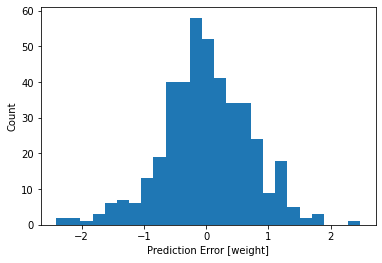

In [ ]:
error = weight_pred.flatten() - test_weight_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [weight]")
_ = plt.ylabel("Count")

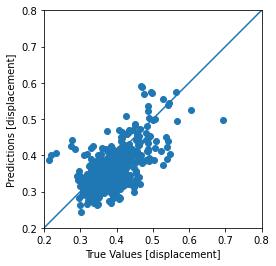

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(displacement_pred, test_displacement_label)
plt.xlabel('True Values [displacement]')
plt.ylabel('Predictions [displacement]')
lims = [0.2, 0.8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

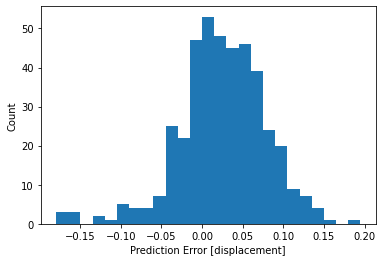

In [ ]:
error = displacement_pred.flatten() - test_displacement_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [displacement]")
_ = plt.ylabel("Count")

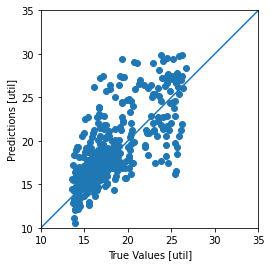

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(util_pred, test_util_label)
plt.xlabel('True Values [util]')
plt.ylabel('Predictions [util]')
lims = [10, 35]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

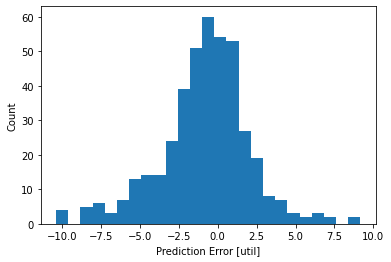

In [ ]:
error = util_pred.flatten() - test_util_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [util]")
_ = plt.ylabel("Count")